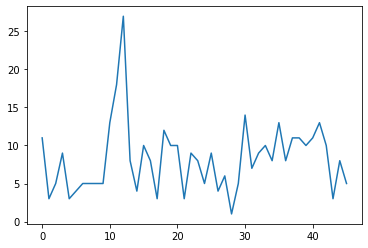

In [317]:
import numpy as np
import pandas as pd
import random
from scipy.special import gamma
from scipy.stats import norm
import matplotlib.pyplot as plt
from math import floor, log, sqrt
from numbers import Number
from statsmodels.graphics.tsaplots import plot_acf
import pymc3 as pm
import arviz as az
chptdat = pd.read_table("COUP551_rates.dat", sep="\s+", usecols=[0, 1], names = ["Time Bin", "Counts"], header=0)
Y = chptdat['Counts']
plt.plot(Y)

In [318]:
def birth(change_points):
    return (3.6/7) * min(1, lambda_1/(change_points+1))
def death(change_points):
    return (3.6/7) * min(1, change_points/lambda_1)
def count_photon(s1, s2, Y):
    sum_v = 0
    for i in range(int(s1), int(s2)):
        sum_v += Y[i]

    return sum_v
# accept probability function for Height move
def alpha_hmove(s, h, h_tilde, j, Y,  a = 5, b= 5.5):
        m = count_photon(s[j], s[j+1], Y)
        log_likelihood_ratio = (h[j] - h_tilde) * (s[j+1] - s[j]) + m*(log(h_tilde) - log(h[j]))
        log_prior_ratio = a * (log(h_tilde) - log(h[j])) - b * (h_tilde - h[j])
        log_pi_ratio = log_likelihood_ratio + log_prior_ratio
        return np.e**(log_pi_ratio)
# accept probability function for Position move
def alpha_smove(s, h, s_tilde, j, Y, a = 5, b= 5.5):
    m1 = count_photon(s[j-1], s[j], Y)
    m1_tilde = count_photon(s[j-1], s_tilde, Y)
    m2 = count_photon(s[j], s[j+1], Y)
    m2_tilde = count_photon(s_tilde,s[j+1], Y)
    log_likelihood_ratio = (h[j] - h[j-1]) * (s_tilde - s[j]) + (m1_tilde - m1) * log(h[j-1]) + (m2_tilde - m2) * log(h[j])
    log_prior_ratio = log((s_tilde - s[j-1])) + log((s[j+1] - s_tilde)) - log(((s[j] - s[j-1]))) - log((s[j+1] - s[j]))
    log_pi_ratio = log_likelihood_ratio + log_prior_ratio
    return np.e**(log_pi_ratio)
# accept probability function for birth of step
def alpha_birth(s,h,s_star,h1_prime,h2_prime,j,k,Y, lambda_1, a = 5, b= 5.5):
        m1_prime = count_photon(s[j],s_star, Y)
        m2_prime = count_photon(s_star,s[j+1], Y)
        mj = m1_prime + m2_prime
        log_likelihood_ratio = (
            - h1_prime * (s_star - s[j]) - h2_prime * (s[j+1] - s_star)
            + m1_prime * log(h1_prime) + m2_prime * log(h2_prime)
            + h[j-1] * (s[j+1] - s[j]) - mj * log(h[j]))
        log_prior_ratio = (log(2) + log(lambda_1) + log(2*k+1)
                           - log(((s[k] - s[0])*(s_star - s[j])*(s[j+1] - s_star))/(s[j+1] - s[j]))
                           + a * log(b) - log(gamma(a)) + (a-1) * (log(h1_prime) + log(h2_prime)) - a * log(h[j])
                           - b * (h1_prime + h2_prime - h[j]))
        log_proposal_ratio = log(death(k)) - log(birth(k-1)) - log(k)
        log_Jacobian = 2 * log(h1_prime + h2_prime)
        log_pi_ratio = log_likelihood_ratio + log_prior_ratio + log_proposal_ratio + log_Jacobian
        return np.e**(log_pi_ratio)
# accept probability function for death of step
def alpha_death(s,h,hj_prime,j,k,Y,lambda_1,a = 5, b= 5.5):
    m1 = count_photon(s[j],s[j+1], Y)
    m2 = count_photon(s[j+1],s[j+2], Y)
    mj_prime = m1 + m2
    log_likelihood_ratio = (
    - hj_prime * (s[j+2] - s[j]) + mj_prime * log(hj_prime)+ h[j] * (s[j+1] - s[j]) + h[j+1] * (s[j] - s[j+1]) - m1 * log(h[j]) - m2 * log(h[j+1])
  )
    log_prior_ratio = ((
    - log(2) - log (lambda_1) - log(2*k-1)
    + log((s[k] - s[0]))) - log((s[j+1] - s[j])) - log((s[j+2] - s[j+1])) + log((s[j+2] - s[j]))
    - a * log(b) + log(gamma(a)) - (a-1) * (log(h[j]) + log(h[j+1])) + a * log(hj_prime)
    + b * (h[j] + h[j+1] - hj_prime))
    log_proposal_ratio = log(birth(k-2)) + log(k-1) -log(death(k-1))
    log_Jacobian = - 2 * log(h[j] + h[j+1])
    log_pi_ratio = log_likelihood_ratio + log_prior_ratio + log_proposal_ratio + log_Jacobian
    return np.e**(log_pi_ratio)

In [319]:
def move(n, h, s, k, lambda_1):
    H = []
    S = []
    K = []
    K.append(k)
    H.append(h)
    for i in s:
        S.append(s)
    for i in range(2,n+1):
        if k <= 1:
            position_prob = 0
        else:
            position_prob = 0.5 * (1 - birth(k-1) - death(k-1))
        #if (k<=1) {position_prob <- 0} else {position_prob <- 0.5 * (1 - birth(k-1) - death(k-1))}
        height_prob = 1 - birth(k-1) - death(k-1) - position_prob
        type_1 = random.random()
        if (type_1>1-height_prob):#from 1 to k is for Height h_1 to h_k
            j = random.randint(0,k-1)
            u = random.uniform(-0.5,0.5)
            h_tilde = h[j] * (np.e**u)
            U = random.random()
            if (U < alpha_hmove(s,h,h_tilde,j,Y)):
                h[j] = h_tilde
        if (type_1<=1-height_prob and type_1>1-height_prob-position_prob):
        #from 2 to k is for Position s_2 to s_k
            j = random.randint(0,k-2)+1
            s_tilde = random.uniform(s[j-1],s[j+1])
            U = random.random()
            if (U < alpha_smove(s,h,s_tilde,j,Y)):
                s[j] = s_tilde

        if (type_1>=birth(k-1) and type_1<=birth(k-1)+death(k-1)):
            j = random.randint(0,k-2)
            r = (s[j+2] - s[j+1]) / (s[j+2] - s[j])
            hj_prime = (h[j]**(1-r)) * (h[j+1]**r) #exp((1-r) * log(h[j]) + r * log(h[j+1]))
            U =  random.random()
            if (U < alpha_death(s,h,hj_prime,j,k,Y,lambda_1)):
                k = k - 1
                h[j] = hj_prime
                del h[j+1]
                del s[j+1]
      

        if (type_1<=birth(k-1)): #from 1 to k is for birth of steps b_1 to b_k
            j = random.randint(0,k-1)
            s_star = random.uniform(s[j],s[j+1])
            u = random.random()
            if ((s[j+1] - s_star)> 0) & ((s[j+1] - s[j]) > 0):
                r = np.e**(log(s[j+1] - s_star) - log(s[j+1] - s[j]))
            else:
                r = 0
            h1_prime = h[j] * (np.e**(r * (log(u) - log(1-u))))
            h2_prime = h[j] * (np.e**((1-r) * (log(1-u) - log(u))))
            U = random.random()
            if (U < alpha_birth(s,h,s_star,h1_prime,h2_prime,j,k,Y, lambda_1)):
                s = s[0:j+1] + [s_star] + s[j+1:k+2]
                if (j > 0):
                    left = h[0:j]
                else:
                     left = []
                if (j < k+1):
                    right = h[j+1:k+1]
                else:
                    right = []
                h = left+[h1_prime]+[h2_prime]+right
                if isinstance(k, int):
                    k  = k+1
                else:
                    k = [i+1 for i in k]
            K.append(k)
            H.append(h)
            S.append(s)
    return [H,K,S]

In [323]:
s = [8,7,6,5,4,3,2,1]
s[0:1]

[8]

(array([7.0000e+00, 0.0000e+00, 7.9010e+03, 0.0000e+00, 0.0000e+00,
        4.1324e+04, 0.0000e+00, 0.0000e+00, 5.9182e+04, 0.0000e+00,
        0.0000e+00, 6.1607e+04, 0.0000e+00, 0.0000e+00, 5.3690e+04,
        0.0000e+00, 0.0000e+00, 4.0177e+04, 0.0000e+00, 0.0000e+00,
        2.5055e+04, 0.0000e+00, 0.0000e+00, 1.3314e+04, 0.0000e+00,
        6.0980e+03, 0.0000e+00, 0.0000e+00, 2.6560e+03, 0.0000e+00,
        0.0000e+00, 1.0960e+03, 0.0000e+00, 0.0000e+00, 4.6000e+02,
        0.0000e+00, 0.0000e+00, 1.9800e+02, 0.0000e+00, 0.0000e+00,
        6.8000e+01, 0.0000e+00, 0.0000e+00, 1.8000e+01, 0.0000e+00,
        5.0000e+00]),
 array([ 1.        ,  1.34782609,  1.69565217,  2.04347826,  2.39130435,
         2.73913043,  3.08695652,  3.43478261,  3.7826087 ,  4.13043478,
         4.47826087,  4.82608696,  5.17391304,  5.52173913,  5.86956522,
         6.2173913 ,  6.56521739,  6.91304348,  7.26086957,  7.60869565,
         7.95652174,  8.30434783,  8.65217391,  9.        ,  9.34782609,
 

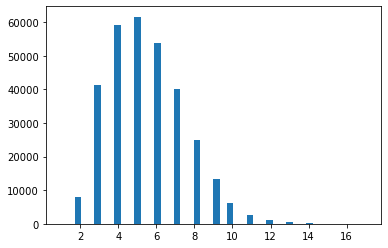

In [324]:
# k0 = 1
# s0 = [1,42]
# h0 = [5]
# lambda_1 = 3
# X = move(1000000, h0, s0, k0, lambda_1)
# H = X[0]
# K = X[1]
# S = X[2]

plt.hist(K,bins=46)
